In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import seaborn as sns
from datetime import datetime, date, timedelta

# Set plotting style
plt.style.use('seaborn-white')

# Plot constants
WIDTH = 10
HEIGHT = 7
BIN_EDGES = np.arange(120)-0.5
plt.rcParams['savefig.bbox'] = 'tight'

%matplotlib inline

In [2]:
# CSV files of tweets
PION_CSV = "./pion_tweets.csv"
KAON_CSV = "./kaon_tweets.csv"

In [3]:
# Load the csv files
pion_df = pd.read_csv(PION_CSV, parse_dates=[3], index_col=0)
kaon_df = pd.read_csv(KAON_CSV, parse_dates=[3], index_col=0)

pion_df["name"] = "pion"
kaon_df["name"] = "kaon"

df = pd.concat([pion_df, kaon_df]) 

In [4]:
# Prune out useless columns
USELESS = [
    'in_reply_to_status_id',
    'in_reply_to_user_id',
    'source',
    'retweeted_status_id',
    'retweeted_status_user_id',
    'retweeted_status_timestamp',
    'expanded_urls',
]

try:  # Prevent error on rerun without reloading the CSV
    df.drop(USELESS, axis=1, inplace=True)
except ValueError:
    pass

In [5]:
# A function to pull out the boot time!
def get_time(tweet):
    # Is it a reboot tweet?
    if "Good morning!" not in tweet:
        return None
    # Otherwise we have a time
    time = tweet.split()[0]
    return datetime.strptime(time, "%H:%M:%S:")

In [6]:
# Extract the time in the text and convert it to seconds after 0100
df['time'] = df['text'].map(get_time)
df['time_delta'] = df['time'].map(lambda x: (x - datetime(1900, 1, 1, 1, 0)).total_seconds())
df['date'] = df['timestamp'].map(lambda x: x.date())

In [7]:
# Remove rows without a time delta
df = df.dropna()

# Remove times the Pis rebooted that was not the scheduled 0100 reboot
df = df[df.time_delta < 600]

In [8]:
pion_data = df[df["name"] == "pion"]["time_delta"]
kaon_data = df[df["name"] == "kaon"]["time_delta"]

In [9]:
# Get summary stats
pion_median = pion_data.median()
kaon_median = kaon_data.median()
print("Pion:", pion_median, "Kaon:", kaon_median)

Pion: 32.0 Kaon: 29.000000000000004


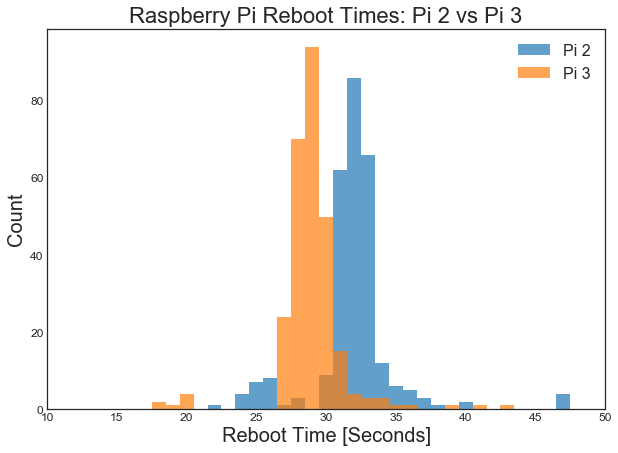

In [10]:
fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))

# Histogram settings
hist_kws={
    "histtype": "stepfilled",
    "linewidth": 2,
    "alpha": 0.7,
}

# Setup data
DATA = (
    (pion_data, "Pi 2"),
    (kaon_data, "Pi 3"),
)

# Make the plot
for x, label in DATA:
    #sns.distplot(x, kde=False, hist_kws=hist_kws, bins=BIN_EDGES, label=label, ax=ax)
    plt.hist(x, bins=BIN_EDGES, label=label, histtype="stepfilled", linewidth=2, alpha=0.7)
        
# Add a legend to the main plot
ax.legend(loc="upper right", fontsize=16)

# Titles
ax.set_title("Raspberry Pi Reboot Times: Pi 2 vs Pi 3", fontsize=22)
ax.set_xlabel("Reboot Time [Seconds]", fontsize=20)
ax.set_ylabel("Count", fontsize=20)

ax.set_xlim(10, 50)
ax.tick_params(axis='both', which='major', labelsize=12)

# Use for the animated plot
XLIM = ax.get_xlim()
YLIM = ax.get_ylim()

# Save to disk
for ext in ("png", "svg"):
    fig.savefig("/tmp/raspberry_pi_reboot_times_2_vs_3.{ext}".format(ext=ext), bbox_inches="tight", dpi=300)

In [11]:
def sequential_dfs(df, start=date(2017, 1, 17), stop=date(2017, 11, 11)):
    delta = stop - start
    for i in range(delta.days + 1):
        current_stop = start + timedelta(days=i)
        yield (df[(df['date'] >= start) & (df['date'] <= current_stop)], current_stop)

Traceback (most recent call last):
  File "/home/agude/bin/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 389, in process
    proxy(*args, **kwargs)
  File "/home/agude/bin/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 227, in __call__
    return mtd(*args, **kwargs)
  File "/home/agude/bin/anaconda/lib/python3.6/site-packages/matplotlib/animation.py", line 1081, in _start
    self._init_draw()
  File "/home/agude/bin/anaconda/lib/python3.6/site-packages/matplotlib/animation.py", line 1792, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
StopIteration


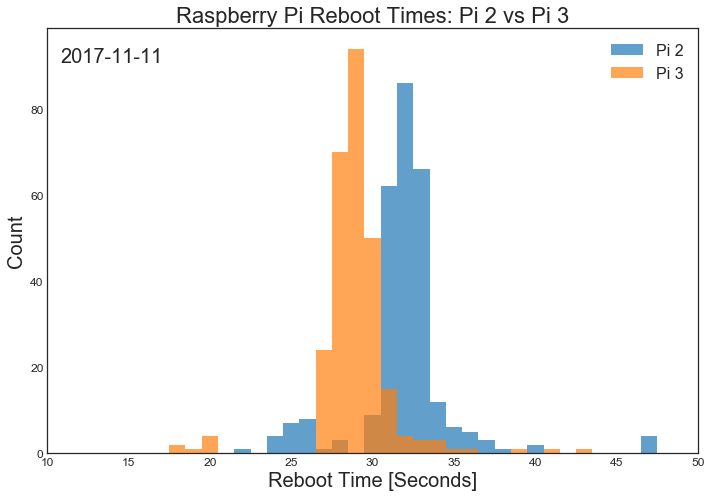

In [12]:
fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))

RUN_COUNT = len(list(enumerate(sequential_dfs(df))))

VIDEO_META = {
    "title": "Raspberry Pi Reboot Times: Pi 2 vs Pi 3",
    "artist": "Alexander Gude",
    "genre": "Scientific",
    "subject": "Raspberry Pi reboot time comparison",
    "copyright": "CC-BY-SA 4.0",
}

ax.set_title("Raspberry Pi Reboot Times: Pi 2 vs Pi 3", fontsize=22)
ax.set_xlabel("Reboot Time [Seconds]", fontsize=20)
ax.set_ylabel("Count", fontsize=20)

fig.tight_layout()

def update(frame):
    plt.gca().cla()
    
    i, (sliced_df, current_date) = frame
    
    # Setup data
    DATA = (
        (sliced_df[sliced_df["name"] == "pion"]["time_delta"], "Pi 2"),
        (sliced_df[sliced_df["name"] == "kaon"]["time_delta"], "Pi 3"),
    )
    
    ax.set_title("Raspberry Pi Reboot Times: Pi 2 vs Pi 3", fontsize=22)
    ax.set_xlabel("Reboot Time [Seconds]", fontsize=20)
    ax.set_ylabel("Count", fontsize=20)

    ax.set_xlim(XLIM)
    ax.set_ylim(YLIM)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Make the plot
    for x, label in DATA:
        plt.hist(x, bins=BIN_EDGES, label=label, histtype="stepfilled", linewidth=2, alpha=0.7)
    # Add a time-stamp
    ax.text(0.02, 0.92, current_date.isoformat(), fontsize=20, transform=ax.transAxes)
    
    ax.legend(loc="upper right", fontsize=16)

anim = animation.FuncAnimation(fig, update, enumerate(sequential_dfs(df)), save_count=RUN_COUNT)
    
anim.save('/tmp/raspberry_pi_reboot_times_2_vs_3_animation.mp4', fps=24, extra_args=['-vcodec', 'libx264'], dpi=300, metadata=VIDEO_META)

plt.show()